In [1]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

train_rest_p = np.stack([np.corrcoef(sub) for sub in train_rest_ts])
test_rest_p = np.stack([np.corrcoef(sub) for sub in test_rest_ts])

# train_nback_p = np.stack([np.corrcoef(sub) for sub in train_nback_ts])
# test_nback_p = np.stack([np.corrcoef(sub) for sub in test_nback_ts])

print(train_rest_p[0].shape)
print('Complete')

(264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [6]:
# Convert to torch

import torch

train_rest_p_torch = torch.from_numpy(train_rest_p).float().cuda()
# train_nback_p_torch = torch.from_numpy(train_nback_p).float()

test_rest_p_torch = torch.from_numpy(test_rest_p).float().cuda()
# test_nback_p_torch = torch.from_numpy(test_nback_p).float()

X_train_torch = torch.from_numpy(X_train).float().cuda()
X_test_torch = torch.from_numpy(X_test).float().cuda()

print(test_rest_p_torch.shape)
print('Complete')

torch.Size([156, 264, 264])
Complete


In [7]:
def makePoly(ps):
    ps3 = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = torch.cat([p, p**2, p**3, p**4, p**5])
        ps3.append(pp)
    return torch.stack(ps3)

print('Complete')

Complete


In [7]:
# Single Gender

def singleGender(ps, X, idx):
    psp = []
    Xp = []
    for i in range(X.shape[0]):
        if X[i,idx] == 1:
            psp.append(ps[i])
            Xp.append(X[i])
    return torch.stack(psp), torch.stack(Xp)

train_rest_p_torch, X_train_torch = singleGender(train_rest_p_torch, X_train_torch, 2)
test_rest_p_torch, X_test_torch = singleGender(test_rest_p_torch, X_test_torch, 2)

print(test_rest_p_torch.shape)
print('Complete')

torch.Size([77, 264, 264])
Complete


In [96]:
import matplotlib.pyplot as plt

# Cosine similarity
def calcEdges(ps1, ps2, mask1, mask2):
    mps1 = torch.einsum('aij,ij->aij',ps1,mask1)
    mps2 = torch.einsum('aij,ij->aij',ps2,mask2)
    e = torch.einsum('aij,bij->ab',mps1,mps2)
    Fps1 = torch.einsum('aij,aij->a',mps1,mps1)**0.5
    Fps2 = torch.einsum('aij,aij->a',mps2,mps2)**0.5
    e /= Fps1.unsqueeze(1)
    e /= Fps2.unsqueeze(1).T
    return e

def threshEdges(edges):
    k = 40
    n = edges.shape[0]
    vals, idcs = torch.sort(edges.flatten())
    edges[edges < vals[-k*n]] = 0.001
    return edges

print('Starting edges')
e = calcEdges(train_rest_p_torch, train_rest_p_torch, torch.ones(264,264), torch.ones(264,264))
e = maskEdges(e)
print('Finished edges')

plt.imshow(e.detach().numpy())
plt.colorbar()
plt.show()

Starting edges


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [17]:
import torch.nn as nn
import torch.nn.functional as F

nRoi = train_rest_p_torch.shape[1]
nLayer = 3
nHid = 20
nFeat = X_train_torch.shape[1]
nHidFeat = 30
nEdge = 1
order = 5

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

def threshEdges(edges):
    k = 40
    n = edges.shape[0]
    vals, idcs = torch.sort(edges.flatten())
    edges[edges < vals[-k*n]] = 0.001
    return edges

# Cosine similarity
def calcEdges(ps1, ps2, mask1, mask2):
    mps1 = torch.einsum('aij,ij->aij',ps1,mask1)
    mps2 = torch.einsum('aij,ij->aij',ps2,mask2)
    e = torch.einsum('aij,bij->ab',mps1,mps2)
    Fps1 = torch.einsum('aij,aij->a',mps1,mps1)**0.5
    Fps2 = torch.einsum('aij,aij->a',mps2,mps2)**0.5
    e /= Fps1.unsqueeze(1)
    e /= Fps2.unsqueeze(1).T
    return normalize(e)

# def attn(atlayers, ps, feat, idx):
#     x = torch.cat([ps,feat[idx]])
#     for layer in atlayers:
#         x = layer(x)
#     return x

def gcn(layers, edges, feat, idx, bn):
#     x = attn(atlayers, ps, feat, idx).unsqueeze(0).unsqueeze(1)
#     edges = x*edges
    
    h = [None]*(nLayer+1)
#     s = torch.einsum('abc->ac',edges).unsqueeze(1)
    h[0] = feat
    
    for i in range(1,nLayer+1):
        h[i] = torch.einsum('abc,bf->afc',edges,h[i-1])
#         h[i] /= s
        h[i] = h[i].reshape(feat.shape[0],-1)
        h[i] = F.relu(layers[i-1](h[i]))
    
    return torch.cat(h[1:], dim=1)

class MaskGcn(nn.Module):
    def __init__(self):
        super(MaskGcn, self).__init__()
        
        # Masks
        self.mask = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
        
        # Attention
#         self.atl1 = nn.Linear(nRoi*nRoi+nFeat,nMask*5).cuda()
#         self.atl2 = nn.Linear(nMask*5,nMask).cuda()
#         self.at = [self.atl1, self.atl2]
        
        # MLP
        self.fc1 = nn.Linear(nRoi*nRoi*order+nHidFeat*nLayer,nHid).cuda()
        self.fc2 = nn.Linear(nHid,1).cuda()
        
        # GCN
        self.l1 = nn.Linear(nFeat*nEdge,nHidFeat).cuda()
        self.l2 = nn.Linear(nHidFeat*nEdge,nHidFeat).cuda()
        self.l3 = nn.Linear(nHidFeat*nEdge,nHidFeat).cuda()
        self.ls = [self.l1,self.l2,self.l3]
        
        # Batch norm 1d
        self.bn = nn.BatchNorm1d(nHidFeat).cuda()
        
    def forward(self, x):
        trainNotTest = x[0]
        
        mask = torch.sigmoid(self.mask)
        
        if trainNotTest:
            idcs = x[1]
            
            # Edges
            e1 = calcEdges(self.ps,self.ps,mask,mask)
            e = torch.stack([e1],dim=2)
            
            # Pearsons
            x = []
            
            # Feat
            h = []
            
            for i in idcs:
                x.append(self.ps[i].flatten())
                feat = self.feat.detach().clone()
                feat[i,0] = 0
                h.append(gcn(self.ls, e, feat, i, self.bn)[i])
            
            x = makePoly(torch.stack(x))
            h = torch.stack(h)
        else:
            aps = x[1] 
            oFeat = x[2].detach().clone()
            
            # Pearsons
            x = makePoly(aps.reshape(aps.shape[0],-1))
            
            # Feat
            h = []
                
            for i in range(len(aps)):
                ps = torch.cat([aps[i].unsqueeze(0), self.ps])

                # Calc edges
                e1 = calcEdges(ps,ps,mask,mask)
                e = torch.stack([e1],dim=2)
                
                # Feat
                feat = torch.cat([oFeat[i:i+1], self.feat])
                feat[0,0] = 0   
                h.append(gcn(self.ls, e, feat, 0, self.bn)[0])
            
            h = torch.stack(h)
        
        x = torch.cat([h,x], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
maskgcn = MaskGcn()
optim_mg = torch.optim.Adam(maskgcn.parameters(), lr=1e-3)

print('Complete')

Complete


In [18]:
import random

N = len(train_rest_p_torch)
running = 0
nEpoch = 1200
pPeriod = 20
nBatch = 20
wd = 20
thresh = 1000

maskgcn.ps = train_rest_p_torch
maskgcn.feat = X_train_torch

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch).cuda()
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        batch.append(idx)
        truth[i] = X_train[idx, 0]
    optim_mg.zero_grad()
    pred = maskgcn([True, batch]) 
    l0 = torch.sum((truth-pred.flatten())**2)
    l1 = torch.tensor(0).float().cuda()
#     for param in [maskgcn.fc1.weight, maskgcn.fc2.weight]:
#         l1 += wd*torch.sum(param**2)
#     for param in maskgcn.parameters():
#         l1 += wd*torch.sum(param**2)
    running += l0.detach().cpu() + l1.detach().cpu()
    loss = l0 + l1
    loss.backward()
    optim_mg.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        if running < thresh:
            break
        running = 0

print('Finished training')

epoch 0 loss=719839.000000
epoch 20 loss=164418.312500
epoch 40 loss=32505.105469
epoch 60 loss=30556.917969
epoch 80 loss=25538.171875
epoch 100 loss=20065.800781
epoch 120 loss=19695.544922
epoch 140 loss=18084.111328
epoch 160 loss=17686.632812
epoch 180 loss=17144.207031
epoch 200 loss=14109.244141
epoch 220 loss=11500.061523
epoch 240 loss=10251.747070
epoch 260 loss=9973.235352
epoch 280 loss=8000.540039
epoch 300 loss=8159.044434
epoch 320 loss=7649.101562
epoch 340 loss=5688.600586
epoch 360 loss=5127.283691
epoch 380 loss=4623.729492
epoch 400 loss=4498.243164
epoch 420 loss=4066.645752
epoch 440 loss=4057.313721
epoch 460 loss=3821.026611
epoch 480 loss=3196.055908
epoch 500 loss=2392.968262
epoch 520 loss=1855.252686
epoch 540 loss=1971.579834
epoch 560 loss=2247.563232
epoch 580 loss=1668.108154
epoch 600 loss=1190.919678
epoch 620 loss=1377.238647
epoch 640 loss=1126.001587
epoch 660 loss=935.971313
Finished training


Doing 
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 
[[1.         0.74601233]
 [0.74601233 1.        ]]
2.0297367046908152
1.608537058544974


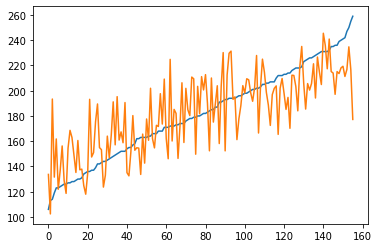

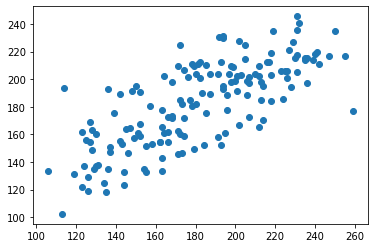

In [19]:
import matplotlib.pyplot as plt
import math

# y = X_train[:,0]
# idcs = torch.arange(0,len(y))
# yPred = maskgcn([True, idcs]).detach().numpy().flatten()

bs = 2
N = X_test.shape[0]
y = X_test[:,0]
ps = test_rest_p_torch
yPred = np.zeros([N])
print('Doing ')
for i in range(math.ceil(N/bs)):
    start = i*bs
    end = start+bs
    if end > N:
        end = N
    print(start, end=' ')
    yPred[start:end] = maskgcn([False, ps[start:end], 
                                X_test_torch[start:end]]).detach().cpu().numpy().flatten()
print()    
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

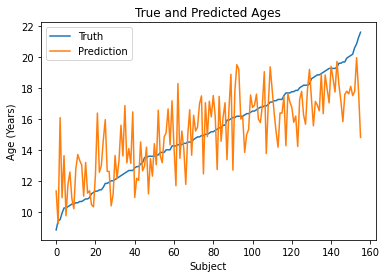

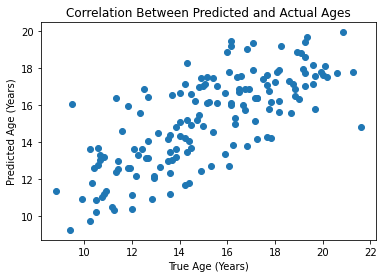

In [13]:
plt.plot(y/12, label='Truth')
plt.plot(yPred/12, label='Prediction')
plt.title('True and Predicted Ages')
plt.ylabel('Age (Years)')
plt.xlabel('Subject')
plt.legend()
plt.show()

plt.scatter(y/12, yPred/12)
plt.title('Correlation Between Predicted and Actual Ages')
plt.ylabel('Predicted Age (Years)')
plt.xlabel('True Age (Years)')
plt.show()

In [15]:
roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [16]:
def rearrange(p,idcs):
    return p[:,idcs][idcs]

mask = rearrange(torch.sigmoid(maskgcn.mask.detach().cpu()), revMap2)

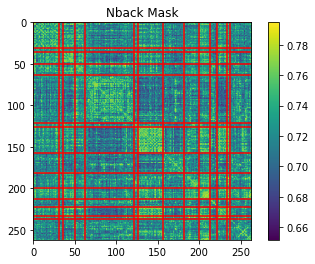

In [17]:
plt.title('Nback Mask')
plt.imshow(mask)
for b in borders1:
    plt.plot([0,263],[b,b],color='red')
    plt.plot([b,b],[0,263],color='red')
plt.xlim(0,263)
plt.ylim(262,0)
plt.colorbar()
plt.show()

In [18]:
# Find greatest average mask

avgs = []

for i in range(1,len(borders1)):
    for j in range(i,len(borders1)):
        xi = borders1[i-1]
        xf = borders1[i]
        yi = borders1[j-1]
        yf = borders1[j]
        n = (xf-xi)*(yf-yi)
        m = mask[xi:xf,yi:yf]
        avg = m.sum()/n
        avgs.append((avg,i,j))
        
avgs.sort(reverse=True, key=lambda a:a[0])
print(avgs)

[(tensor(0.7602), 10, 10), (tensor(0.7571), 6, 6), (tensor(0.7550), 7, 7), (tensor(0.7529), 12, 12), (tensor(0.7523), 7, 13), (tensor(0.7509), 3, 3), (tensor(0.7507), 7, 12), (tensor(0.7505), 12, 13), (tensor(0.7483), 10, 13), (tensor(0.7482), 13, 13), (tensor(0.7472), 2, 2), (tensor(0.7464), 4, 4), (tensor(0.7426), 6, 13), (tensor(0.7425), 3, 10), (tensor(0.7425), 7, 10), (tensor(0.7420), 1, 1), (tensor(0.7418), 9, 10), (tensor(0.7408), 10, 12), (tensor(0.7405), 2, 12), (tensor(0.7398), 10, 14), (tensor(0.7395), 3, 12), (tensor(0.7387), 6, 12), (tensor(0.7383), 9, 9), (tensor(0.7382), 3, 13), (tensor(0.7381), 5, 5), (tensor(0.7380), 11, 11), (tensor(0.7377), 1, 10), (tensor(0.7370), 9, 13), (tensor(0.7366), 1, 3), (tensor(0.7364), 3, 6), (tensor(0.7359), 2, 10), (tensor(0.7352), 3, 4), (tensor(0.7342), 3, 9), (tensor(0.7342), 2, 3), (tensor(0.7342), 2, 7), (tensor(0.7341), 6, 9), (tensor(0.7337), 6, 10), (tensor(0.7336), 1, 13), (tensor(0.7333), 1, 12), (tensor(0.7333), 1, 2), (tensor

In [198]:
mAges = []
fAges = []

for t in train+test:
    if t['meta']['Gender'] == 'M':
        mAges.append(t['meta']['AgeInMonths'])
    else:
        fAges.append(t['meta']['AgeInMonths'])

ages = mAges+fAges

mAges = np.array(mAges)
fAges = np.array(fAges)
ages = np.array(ages)

print(len(mAges))
print(len(fAges))
print(len(ages))

print(np.mean(mAges)/12)
print(np.mean(fAges)/12)
print(np.mean(ages)/12)

print(np.std(mAges/12))
print(np.std(fAges/12))
print(np.std(ages/12))

279
343
622
14.922341696535247
15.234450923226433
15.094453376205786
3.1283512738950963
3.3706609509073697
3.26788631554081


In [334]:
train_rest_p.shape

(467, 264, 264)